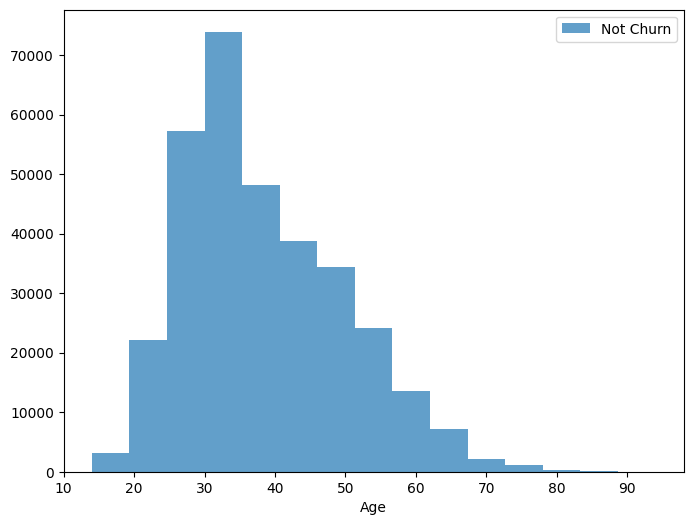

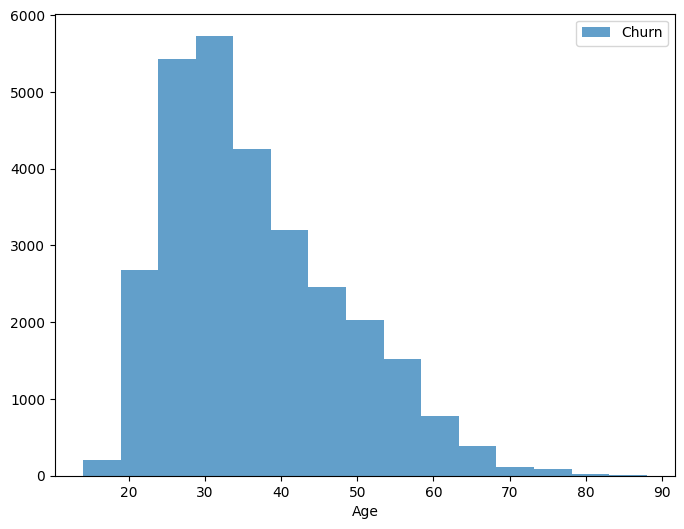

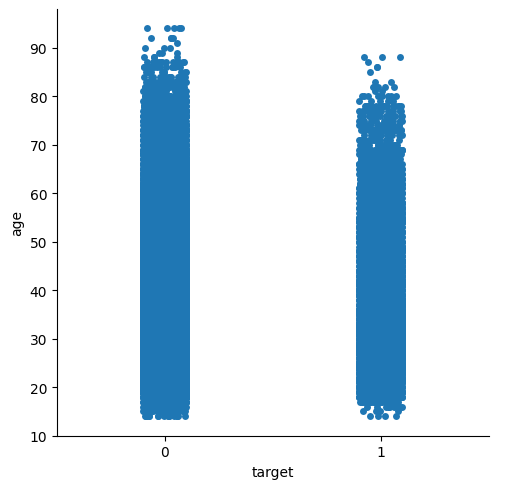

       id  cr_prod_cnt_il  amount_rub_clo_prc  turnover_dynamic_il_1m  \
0  146841               0            0.000000                     0.0   
1  146842               0            0.041033                     0.0   
2  146843               0            0.006915                     0.0   
3  146844               0            0.000000                     0.0   
4  146845               0            0.000000                     0.0   

   amount_rub_sup_prc  rest_dynamic_fdep_1m  rest_dynamic_save_3m  \
0            0.000000                   0.0              0.541683   
1            0.244678                   0.0              0.000000   
2            0.000000                   0.0              0.000000   
3            0.000000                   0.0              0.005874   
4            0.000000                   0.0              0.000000   

   cr_prod_cnt_vcu   rest_avg_cur  amount_rub_nas_prc  trans_count_sup_prc  \
0                0  156067.339800                 0.0             0.

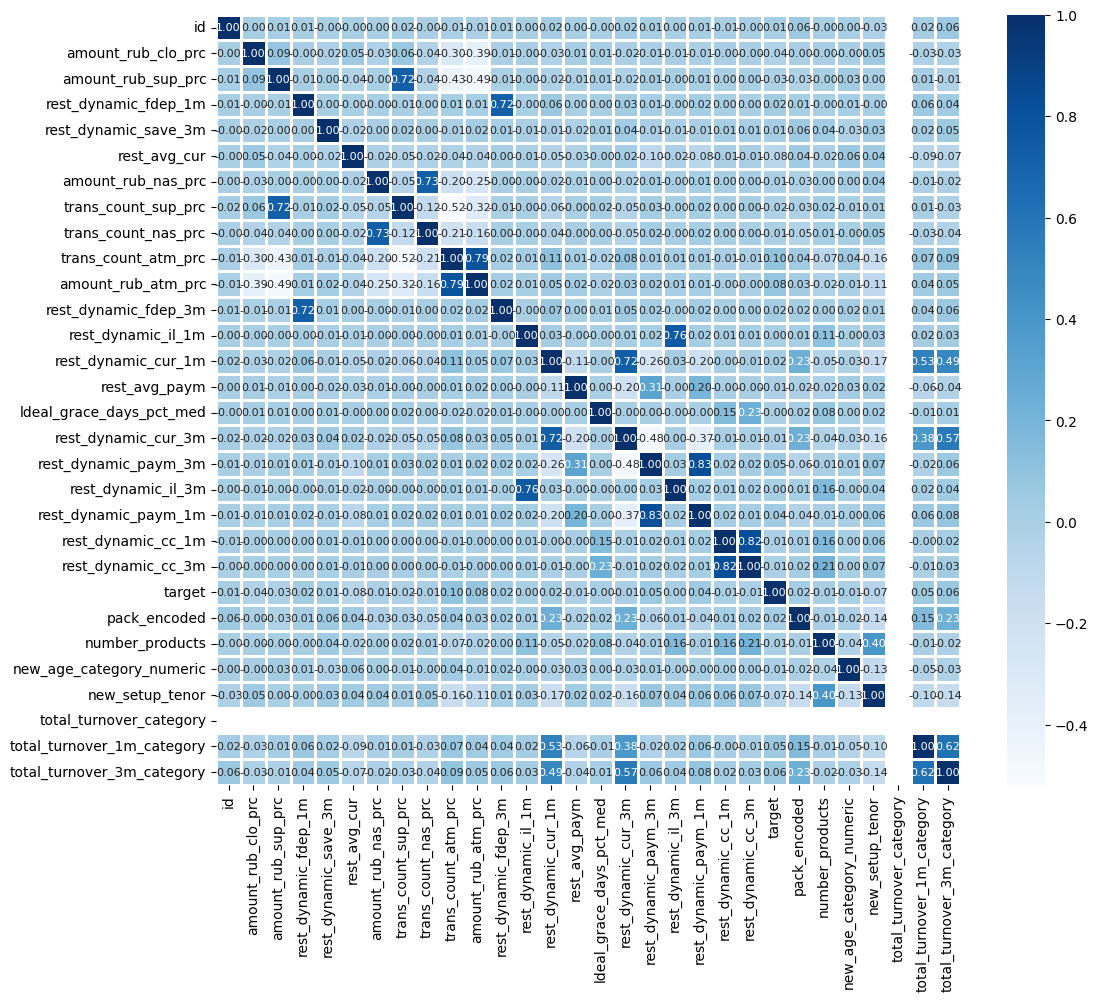

File 'dev/final/bank_data_feature_eng.csv' successfully written to bucket 'introtoaiwinter24'.


In [1]:
#%run main.ipynb
#%run data_cleaning.ipynb
#%run data_visualization.ipynb
%run feature_engineering.ipynb

In [2]:
# Read the CSV From FEATURE ENGINEERING data source file from S3 into a DataFrame
# Use the methods from the S3Utils class
if s3_utils.check_file_exists(output_file_key_data_feature_engineering):
    dataset = s3_utils.read_csv_from_s3(output_file_key_data_feature_engineering)

In [3]:
import shap

from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Select the features to include just to check the model performance
selected_features = ['id','new_age_category_numeric', 'pack_encoded', 'number_products', 'new_setup_tenor', 'rest_avg_paym', 'rest_dynamic_cur_3m','rest_dynamic_fdep_3m']
['id', 'amount_rub_clo_prc', 'amount_rub_sup_prc', 'rest_dynamic_save_3m', 'rest_avg_cur', 'amount_rub_nas_prc', 'amount_rub_atm_prc', 'rest_dynamic_fdep_3m', 'rest_avg_paym', 'ldeal_grace_days_pct_med', 'rest_dynamic_cur_3m', 'rest_dynamic_paym_3m', 'rest_dynamic_il_3m', 'rest_dynamic_cc_3m', 'target', 'pack_encoded', 'number_products', 'new_age_category_numeric', 'new_setup_tenor', 'total_turnover_category', 'total_turnover_1m_category', 'total_turnover_3m_category']

# Split the dataset into features (X) and target variable (y) using the selected features
X = dataset[selected_features]
X = dataset.drop(columns=['target'])
y = dataset['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def get_null_value_counts(df):
    null_counts = df.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    null_counts = null_counts.sort_values(ascending=False)
    null_percentages = (null_counts / len(df)) * 100
    null_data_types = df[null_counts.index].dtypes
    null_values = pd.concat([null_counts, null_percentages, null_data_types], axis=1, keys=['Null Count', 'Null Percentage', 'Data Type'])
    return null_values

null_values = get_null_value_counts(dataset)
print(null_values)

                    Null Count  Null Percentage Data Type
amount_rub_clo_prc       38323        10.789437   float64
amount_rub_sup_prc       38323        10.789437   float64
amount_rub_nas_prc       38323        10.789437   float64
amount_rub_atm_prc       38323        10.789437   float64


In [5]:
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Columns to be imputed
columns_to_impute = ['amount_rub_clo_prc', 'amount_rub_sup_prc', 'amount_rub_nas_prc', 'amount_rub_atm_prc']

# Perform imputation
dataset[columns_to_impute] = imputer.fit_transform(dataset[columns_to_impute])

In [6]:
# Define X_train_scaled and X_test_scaled 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.transform(X_test_scaled)

In [7]:
scaler = StandardScaler()

# Fit on training set only
X_train_scaled = scaler.fit_transform(X_train)

# Apply transform to the test set
X_test_scaled = scaler.transform(X_test)

Check for Class Imbalance

In [8]:
# Count the occurrences of each class in the target variable
class_counts = np.bincount(y_train)

# Find the class label with the majority
class_labels = np.unique(y_train)
class_counts_dict = {label: count for label, count in zip(class_labels, class_counts)}

print("Class counts:", class_counts_dict)

Class counts: {0: 228379, 1: 20254}


In [9]:
# Apply the SMOTE algorithm to the training data for class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train)

In [10]:
# Check the new class distribution
new_class_counts = np.bincount(y_train_smote)
new_class_counts_dict = {label: count for label, count in zip(np.unique(y_train_smote), new_class_counts)}

print("Class counts after SMOTE:", new_class_counts_dict)

Class counts after SMOTE: {0: 228379, 1: 228379}


Both classes (0 and 1) have an equal number of instances (228379 each), which should help mitigate the issues associated with training a machine learning model on imbalanced data.

Model Training with XGBoost Classifier

In [11]:
# Initialize the XGBClassifier with specified parameters
xgb_classifier = XGBClassifier(
    random_state=42,         
    use_label_encoder=False, 
    eval_metric='auc',  
    scale_pos_weight=1       
)

In [12]:
# Fit the model on the balanced training data (SMOTE applied)
xgb_classifier.fit(
    X_train_smote, 
    y_train_smote,
    eval_set=[(X_test_scaled, y_test)], 
    early_stopping_rounds=10,          
    verbose=False                      
)

/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [13]:
# Make predictions on the test data
predictions = xgb_classifier.predict(X_test_scaled)

# Evaluate predictions with accuracy and classification report
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)
print(classification_report(y_test, predictions))

Accuracy: 0.841014668205749
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     97886
           1       0.22      0.37      0.28      8671

    accuracy                           0.84    106557
   macro avg       0.58      0.63      0.59    106557
weighted avg       0.88      0.84      0.86    106557



In [14]:
# Calculate Precision, Recall, and F1 Score for the model
precision = precision_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.21882224942200462
Recall: 0.3711221312420713
F1 Score: 0.27531334217393166


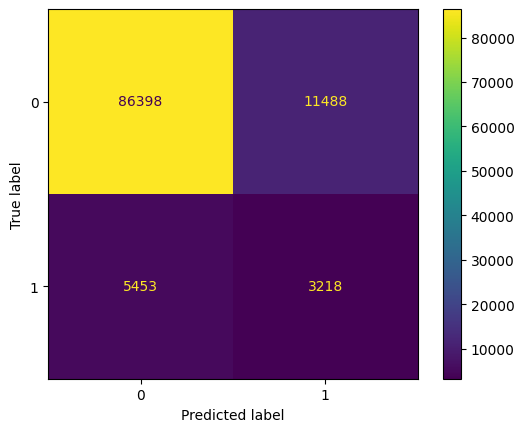

In [15]:
# Create confusion matrix
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot()

In [16]:
# Use probability of the positive class for ROC metrics
probabilities = xgb_classifier.predict_proba(X_test_scaled)[:, 1]

ROC AUC score: 0.7635068359772106


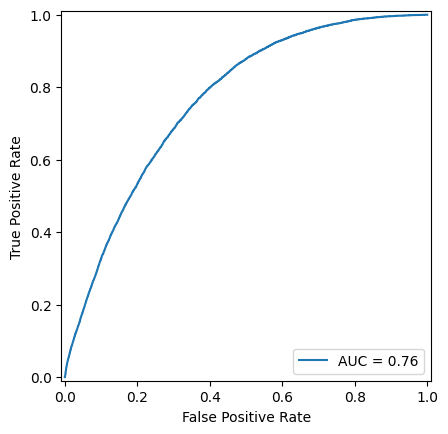

In [17]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

# Calculate the ROC AUC
roc_auc = roc_auc_score(y_test, probabilities)

print(f"ROC AUC score: {roc_auc}")

# Display the ROC curve
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

Hyperparameter Tuning

To find the best parameter GridSearchCV and Randomized search CV will be used. The below code is used to train the model and find the best parameters.

In [18]:
# Define the parameter grid specifically for XGBClassifier
param_grid = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [None, 5, 10], 
    'min_child_weight': [1, 2, 5], 
    'colsample_bytree': [0.3, 0.7],  
    'learning_rate': [0.01, 0.1, 0.2]  
}

In [19]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Initialize the GridSearchCV object with the necessary parameters
grid_search = GridSearchCV(
    estimator=XGBClassifier(
        random_state=42,         
        use_label_encoder=False, 
        eval_metric='auc'        
    ),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='roc_auc'
)

# X_train and y_train as training data and labels
grid_search.fit(X_train, y_train)

# Access the best parameters and the best model
best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_parameters)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


/home/codespace/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': None, 'min_child_weight': 5, 'n_estimators': 200}


In [20]:
from xgboost import XGBClassifier

# Initialize the XGBClassifier
optimized_xgb = XGBClassifier(
    n_estimators=best_parameters['n_estimators'],
    max_depth=best_parameters['max_depth'],
    min_child_weight=best_parameters['min_child_weight'],
    colsample_bytree=best_parameters['colsample_bytree'],
    learning_rate=best_parameters['learning_rate'],
    random_state=42,
    use_label_encoder=False,  
    eval_metric='auc'
)

# Fit the optimized model on the training data
optimized_xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Hyperparameter Optimization with RandomizedSearchCV

In [21]:
# Define the parameter space
params = {
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1),
    'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
    'n_estimators': [100, 250, 500, 750],
    'reg_alpha': [0.1, 0.001, 0.00001],
    'reg_lambda': [0.1, 0.001, 0.00001]
}

In [22]:
# Initialize the XGBClassifier
xgb_classifier = XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc'
)

In [23]:
# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=params,
    n_iter=100,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    verbose=3,
    random_state=42
)

In [24]:
# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[CV 3/5] END colsample_bylevel=0.5, colsample_bytree=0.8999999999999999, learning_rate=0.1, max_depth=15, n_estimators=750, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5;, score=0.766 total time= 1.4min
[CV 2/5] END colsample_bylevel=0.5, colsample_bytree=0.8999999999999999, learning_rate=0.1, max_depth=15, n_estimators=750, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5;, score=0.773 total time= 1.4min
[CV 1/5] END colsample_bylevel=0.5, colsample_bytree=0.8999999999999999, learning_rate=0.1, max_depth=15, n_estimators=750, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5;, score=0.770 total time= 1.4min


/home/codespace/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 4/5] END colsample_bylevel=0.5, colsample_bytree=0.8999999999999999, learning_rate=0.1, max_depth=15, n_estimators=750, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5;, score=0.767 total time= 1.4min
[CV 1/5] END colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=750, reg_alpha=0.1, reg_lambda=0.001, subsample=0.5;, score=0.801 total time=  13.5s
[CV 2/5] END colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=750, reg_alpha=0.1, reg_lambda=0.001, subsample=0.5;, score=0.803 total time=  13.6s
[CV 3/5] END colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=750, reg_alpha=0.1, reg_lambda=0.001, subsample=0.5;, score=0.803 total time=  13.9s
[CV 4/5] END colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=750, reg_alpha=0.1, reg_lambda=0.001, subsample=0.5;, score=0.808 total time=  13.7s
[CV 5/5] END colsample_bylevel=0.5, colsample_

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                   param_distributions={'colsample_bylevel': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3,
                                                          0.4],
                                        'max_depth': [3, 6, 10, 15],
                                        'n_estimators': [100, 250, 500, 750],
                                        'reg_alpha': [0.1, 0.001, 1e-05],
                                        'reg_lambda': [0.1, 0.001, 1e-05],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42, scoring='roc_auc', verbose=3)

In [25]:
# After fitting, you can get the best parameters and the best score
print("Best parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

Best parameters:  {'subsample': 0.7999999999999999, 'reg_lambda': 0.001, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6}
Best Score:  0.8084078261542622


In [26]:
# Evaluate the best model on the test set
best_model = random_search.best_estimator_

Precision: 0.5819672131147541
Recall: 0.01637642717102987
F1 Score: 0.031856421761076836
ROC AUC: 0.81


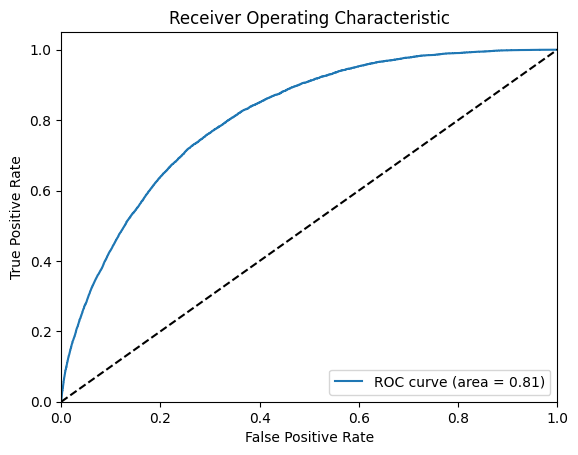

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     97886
           1       0.58      0.02      0.03      8671

    accuracy                           0.92    106557
   macro avg       0.75      0.51      0.49    106557
weighted avg       0.89      0.92      0.88    106557



In [27]:
# Function to evaluate the model
# y_true: The true labels from the test dataset.
# y_pred: The predictions made by the model on the test dataset.

def model_eval(y_true, y_pred, y_proba):
    print("Precision:", precision_score(y_true, y_pred, average='binary'))
    print("Recall:", recall_score(y_true, y_pred, average='binary'))
    print("F1 Score:", f1_score(y_true, y_pred, average='binary'))

    # ROC AUC score
    roc_auc = roc_auc_score(y_true, y_proba[:, 1])  
    print(f'ROC AUC: {roc_auc:.2f}')
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_proba[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Make predictions on the test set
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)

# Call the evaluation function, including ROC AUC and ROC curve plotting
model_eval(y_test, y_test_pred, y_test_proba)

# Print classification report
print(classification_report(y_test, y_test_pred))

Feature Importance using SHAP

Use SHAP (SHapley Additive exPlanations)to understand the contribution of each feature to the predictions made by the model. SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction if that feature took some baseline value.

In [28]:
# Create a SHAP explainer object.
explainer = shap.Explainer(best_model)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

 Visualize Feature Importance

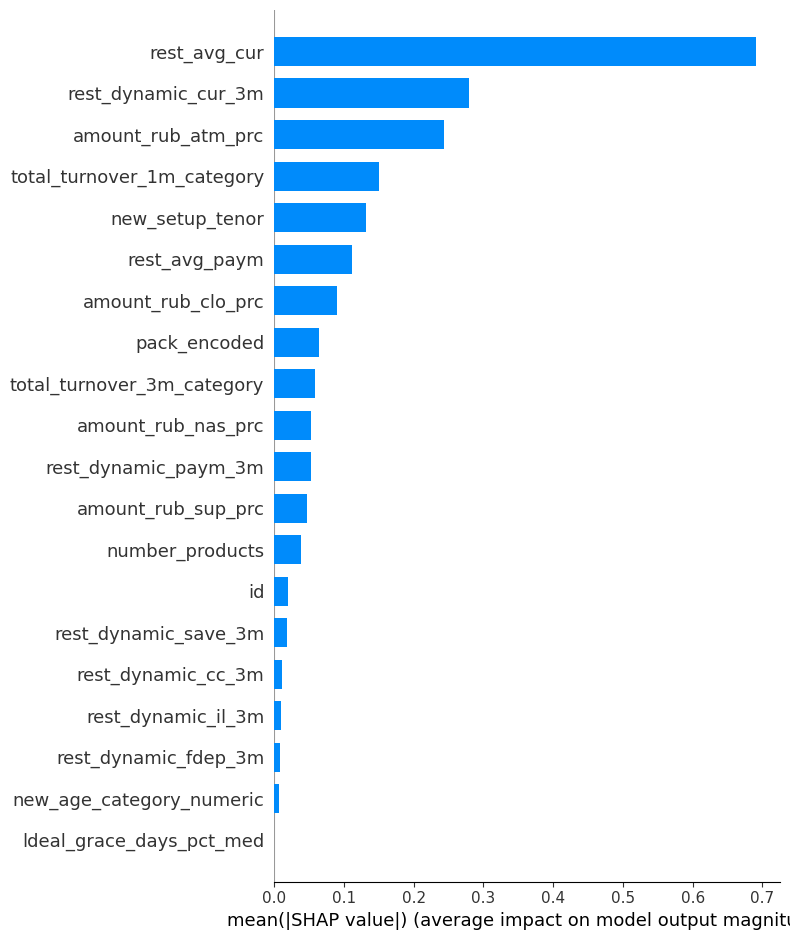

In [29]:
# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")


Global Interpretation: The most impactful feature is rest_avg_cur, which has the highest mean absolute SHAP value. This suggests that it has the most substantial influence on the model's predictions.
The next most important features, rest_dynamic_cur_3m and amount_rub_atm_prc, also have significant SHAP values, indicating strong impacts on model predictions but to a lesser extent than rest_avg_cur.

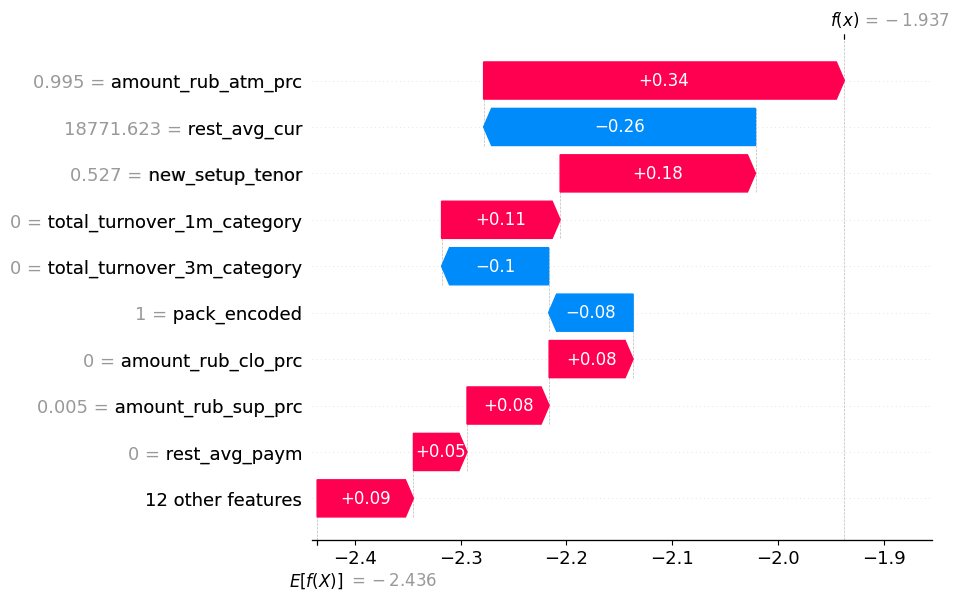

In [30]:
#SHAP Waterfall Plot
shap.plots.waterfall(shap_values[0])

Local Interpretation: 'amount_rub_atm_prc' has a high positive SHAP value, indicating that for this particular customer, having a higher value for this feature contributes to a higher likelihood of churning according to the model. Conversely, 'rest_avg_cur' has a large negative SHAP value, suggesting that this feature's value contributes to decreasing the likelihood of churning for this customer.

Serialize the XGBoost Model

In [31]:
import joblib

# Serialize the XGBoost model stored in xgb_classifier
joblib.dump(xgb_classifier, 'xgboost_model.pkl')

['xgboost_model.pkl']

Create a TAR File Containing the PKL File

In [32]:
import tarfile

# Create a tar.gz archive containing the serialized model
with tarfile.open('model_artifacts.tar.gz', 'w:gz') as tar:
    tar.add('xgboost_model.pkl')